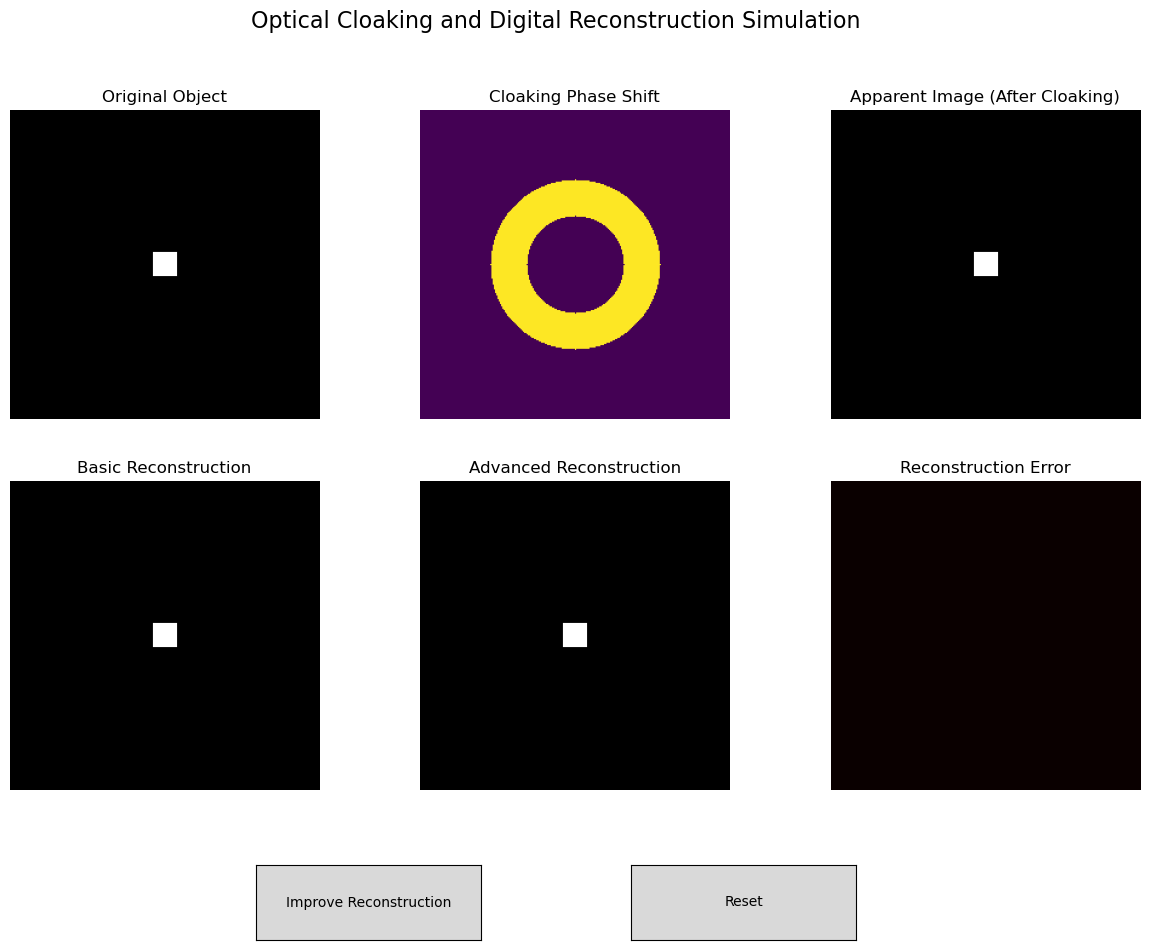

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import shift

# Set up the simulation parameters
grid_size = 256
wavelength = 0.05  # Reduced wavelength for better visualization
obj_size = 20
cloak_outer_radius = 70
cloak_inner_radius = 40
refractive_index = 2.0  # Refractive index of the cloaking material

# Create the object (a simple square)
def create_object(size):
    obj = np.zeros((grid_size, grid_size))
    start = grid_size // 2 - size // 2
    end = grid_size // 2 + size // 2
    obj[start:end, start:end] = 1.0
    return obj

# Create the cloaking device (annular region)
def create_cloak(outer_radius, inner_radius):
    y, x = np.ogrid[-grid_size//2:grid_size//2, -grid_size//2:grid_size//2]
    mask = x**2 + y**2 <= outer_radius**2
    inner_mask = x**2 + y**2 <= inner_radius**2
    cloak = mask.astype(float) - inner_mask.astype(float)
    return cloak

# Function to calculate phase shift from refraction
def calculate_phase_shift(cloak, refractive_index, wavelength):
    # Phase shift is proportional to the refractive index difference and thickness
    # For simplicity, we'll use a constant phase shift in the cloaking region
    phase_shift = cloak * (refractive_index - 1) * 10 * wavelength
    return phase_shift

# Apply cloaking by refracting light rays
def apply_cloaking(object_wave, phase_shift):
    # Simulate the effect of refraction by applying a phase shift
    cloaked_wave = object_wave * np.exp(1j * phase_shift)
    return cloaked_wave

# Attempt to reconstruct the object from refracted rays
def reconstruct_object(cloaked_wave, phase_shift):
    # Try to reverse the phase shift
    reconstructed_wave = cloaked_wave * np.exp(-1j * phase_shift)
    return np.abs(reconstructed_wave)

# Create the figure and UI
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(bottom=0.2)

# Create object and cloak
object_img = create_object(obj_size)
cloak = create_cloak(cloak_outer_radius, cloak_inner_radius)
phase_shift = calculate_phase_shift(cloak, refractive_index, wavelength)

# Initial display
object_display = axes[0, 0].imshow(object_img, cmap='gray')
axes[0, 0].set_title('Original Object')
axes[0, 0].axis('off')

cloak_display = axes[0, 1].imshow(phase_shift, cmap='viridis')
axes[0, 1].set_title('Cloaking Phase Shift')
axes[0, 1].axis('off')

# Simulate wave propagation
object_wave = np.sqrt(object_img)  # Amplitude of the wave

# Apply cloaking
cloaked_wave = apply_cloaking(object_wave, phase_shift)
cloaked_display = axes[0, 2].imshow(np.abs(cloaked_wave)**2, cmap='gray')
axes[0, 2].set_title('Apparent Image (After Cloaking)')
axes[0, 2].axis('off')

# Try to reconstruct
reconstructed = reconstruct_object(cloaked_wave, phase_shift)
reconstruction_display = axes[1, 0].imshow(reconstructed, cmap='gray')
axes[1, 0].set_title('Basic Reconstruction')
axes[1, 0].axis('off')

# More advanced reconstruction attempt
def advanced_reconstruction(cloaked_wave, phase_shift, iterations=5):
    # Initialize with the basic reconstruction
    current_estimate = reconstruct_object(cloaked_wave, phase_shift)
    
    # Simple iterative approach to improve reconstruction
    for _ in range(iterations):
        # Apply constraints (object must be real and positive)
        current_estimate = np.maximum(current_estimate, 0)
        
        # Apply support constraint (object is within a certain region)
        support = np.zeros_like(current_estimate)
        center = grid_size // 2
        support[center-obj_size-10:center+obj_size+10, 
                center-obj_size-10:center+obj_size+10] = 1
        current_estimate = current_estimate * support
        
    return current_estimate

advanced_recon = advanced_reconstruction(cloaked_wave, phase_shift)
advanced_display = axes[1, 1].imshow(advanced_recon, cmap='gray')
axes[1, 1].set_title('Advanced Reconstruction')
axes[1, 1].axis('off')

# Difference image
difference = np.abs(object_img - reconstructed)
diff_display = axes[1, 2].imshow(difference, cmap='hot')
axes[1, 2].set_title('Reconstruction Error')
axes[1, 2].axis('off')

# Add buttons for interaction
ax_button = plt.axes([0.3, 0.05, 0.15, 0.075])
btn_improve = Button(ax_button, 'Improve Reconstruction')

ax_reset = plt.axes([0.55, 0.05, 0.15, 0.075])
btn_reset = Button(ax_reset, 'Reset')

# Counter for improvement iterations
improve_count = 0

def improve_reconstruction(event):
    global improve_count, advanced_recon, advanced_display
    improve_count += 1
    advanced_recon = advanced_reconstruction(cloaked_wave, phase_shift, iterations=5+improve_count*2)
    advanced_display.set_data(advanced_recon)
    advanced_display.set_clim(advanced_recon.min(), advanced_recon.max())
    
    # Update difference image
    new_diff = np.abs(object_img - advanced_recon)
    diff_display.set_data(new_diff)
    diff_display.set_clim(new_diff.min(), new_diff.max())
    
    plt.draw()

def reset_simulation(event):
    global improve_count, advanced_recon
    improve_count = 0
    advanced_recon = advanced_reconstruction(cloaked_wave, phase_shift, iterations=5)
    advanced_display.set_data(advanced_recon)
    advanced_display.set_clim(advanced_recon.min(), advanced_recon.max())
    
    # Reset difference image
    diff_display.set_data(np.abs(object_img - advanced_recon))
    diff_display.set_clim(0, 1)
    
    plt.draw()

btn_improve.on_clicked(improve_reconstruction)
btn_reset.on_clicked(reset_simulation)

plt.suptitle('Optical Cloaking and Digital Reconstruction Simulation', fontsize=16)
plt.savefig("figure")
plt.show()